# Klasyfikacja Fake Newsów - Projekt 1

### Wstęp do uczenia maszynowego, 2022/2023 r.
### Alicja Charuza, Mateusz Gałęziewski

dataset: https://www.kaggle.com/datasets/mohammadaflahkhan/fake-news-dataset-combined-different-sources

### Wstęp

Zbiór danych, na którym pracujemy to dane tekstowe z rozmaitych źródeł internetowych. Zawiera on zarówno informacje (fałszywe i prawdziwe) oraz takie rekordy, które można sklasyfikować jako spam bądź wiadomości puste/bez informacji. 
Naszym zadaniem jest przeprowadzenie selekcji modeli do detekcji konkretnego zjawiska, czyli publikacji fałszywych informacji.
Działania dezinformacyjne mogą przybierać różną formę, mieć różny cel i szczebel na jakim oddziałują. Mogą udostępniać fałszywe informacje na temat pojedynczych osób czy grup ludzi - działanie na niższym szczeblu. Mogą również destablilizowć sytuację wewnętrzną w danym państwie zarówno dla korzyści poszczególnych oponentów politycznych jak i interesariuszy z państw trzecich. Rozprzetrzenianie się fałszywych informacji może mieć również wymiar gospodarczy działając np. na szkodę lub zysk jakiejś korporacji bądź jej produktu, inwestycji.
Problem potęguje postępująca obecnie rewolucja informacyjna oraz wzrost liczby użytkowników internetu. Sfera informacyjna staje się bardziej podatna na takie zagrożenia jak rozprzestrzenianie się fake newsów.
Dlatego my bazując na udostępnionym zbiorze danych spróbujemy takie fałszywe informacje wyłapać i przygotować na nich model odpowiednio klasyfikujący przyszłe dane tekstowe. 

### Eksploracyjna analiza danych (EDA) i preprocessing
Zaczynając od zapoznania się ze zbiorem danych rozpoczynamy proces przetwarznia tych danych. Proces ten polega na przeprowadzeniu takich operacji na danych tekstowych, aby można było zaimplementować te dane w modelach klasycznego uczenia maszynowego nadzorowanego.
Na początku zdecydowaliśmy się przeprowadzić detekcję języków znajdujących się w zbiorze danych dodając etykietę w jakim języku wykonano wpis, i po eksploracyjnej analizie danych postanowiluśmy usunąć wpisy w języku innym niż angielski. Zadecydowała o tym bardzo mała ilość oraz wysokie niezbalansowanie wpisów w innych językach. Gdybyśmy tworzyli model ze wszystkimi językami defacto automatycznie nieangielskie rekordy klasyfikowane by były jako 'fake', model mógłby brać to pod uwagę. Przecież nie może każdy wpis w języku innym niż angielski być z góry fałszywy, myślmy realnie. 
Następnie przeprowadziliśmy czyszczenie danych tekstowych ze znaków interpunkcyjnych, specjalnych itp. Pozbyliśmy się również 'stopwordów' czyli takich wyrazów często się pojawiających, lecz nie niosących informacji oraz wierszy z pustymi polami czy zawierającymi jednynie link. Sprowadziliśmy wszystko do małej litery.
Na koniec przeprowadziliśmy stemizację, czyli obcięcie wszelkiego rodzaju przedrostków i przyrostków słowa, aby dotrzeć do tzw. rdzenia danego słowa.
Ostatnią, lecz bardzo ważną operacją było przeprowadzenie wektoryzacji słów i zamianę zbioru danych na macierz TF-IDF (TF - Term Frequency, IDF - Inverse Document Frequency). Jest to statystyczna metoda obliczania wagi słów dla przetwarzania danych tekstowych przedstawiająca w takiej macierzy (TF) ilość wystąpień słowa w danym tekscie na (IDF) częstość wystąpienia danego słowa uwzględniając unikalność danego słowa. Określa współczynnik ważności słowa (dana wartość z macierzy tf-idf rośnie jeśli jakieś słowo pojawia się często w jednym tekście, natomiast rzadko w innych).

### Co dalej?
Przetestujemy kilka modeli wraz z różnymi parametrami by zobaczyć jak radzą sobie z klasyfikacją. Na koniec wybierzemy jeden, zostanie on wdrożony przez nas do wykonania zadania klasyfikacji nowych fake newsów. 

In [1]:
#imports
import os
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
import joblib
import pickle
import wordcloud
import matplotlib.pyplot as plt
from scipy.stats import loguniform


### Pobieranie danych

In [2]:
#load the training data
x_train = pd.read_csv('train_data/tfidf_train_train.csv', index_col=[0])
y_train = pd.read_csv('train_data/y_train_train.csv', index_col=[0])
#load the test data
x_test = pd.read_csv('train_data/tfidf_train_test.csv', index_col=[0])
y_test = pd.read_csv('train_data/y_train_test.csv', index_col=[0])
#training data shape
x_train.shape

(32988, 2885)

In [3]:
# solving problems with index after loading data
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Definiujemy funkcje zliczające metryki do oceny modelu, będziemy się nimi kierować przy ostatecznym doborze modelu na wdrożenie 
 
 *Niektóre modele jak np. LinearSVC czy MLPClassifier nie przyjmują metody '.predict_proba', natomiast np. drzewa decyzyjne czy lasy losowe nie przyjmują '.decision_function'. 
 Stworzyliśmy zatem dwie funkcje po to by pokazać ROC AUC dla każdego modelu.

In [10]:
# model performance and metrices
def show_results(model, x, y):
    predict = model.predict(x)
    print('F1 score:',f1_score(y, predict))
    print('Accuracy:',accuracy_score(y, predict))
    print('Recall:',recall_score(y, predict))
    print('Precision:',precision_score(y, predict))
    print('ROC AUC:', roc_auc_score(y, model.decision_function(x)))

In [18]:
# model performance and metrices
def show_results2(model, x, y):
    predict = model.predict(x)
    print('F1 score:',f1_score(y, predict))
    print('Accuracy:',accuracy_score(y, predict))
    print('Recall:',recall_score(y, predict))
    print('Precision:',precision_score(y, predict))
    print('ROC AUC:', roc_auc_score(y, model.predict_proba(x)[:, 1]))


## Regresja logistyczna

In [15]:
# no parameters
log_reg=LogisticRegression(random_state=42)
log_reg.fit(x_train, y_train.values.ravel())
print('Logistic Regression:')
print()
print('Train results:')
show_results(log_reg, x_train, y_train)
print()
print('Test results:')
show_results(log_reg, x_test, y_test)

Logistic Regression:

Train results:
F1 score: 0.942822994178201
Accuracy: 0.9550497090203686
Recall: 0.9288915900630555
Precision: 0.9571786441208705
ROC AUC: 0.9904571804494791

Test results:
F1 score: 0.9371367253867477
Accuracy: 0.9502547410133031
Recall: 0.922048213971494
Precision: 0.9527272727272728
ROC AUC: 0.9869544663411631


In [6]:
#RandomizedSearch for Logistic Regression
params = {'C': np.logspace(-3, 2, 6)}

log_reg=LogisticRegression(random_state=42, solver='saga', max_iter=100)
rand_search = RandomizedSearchCV(log_reg, param_distributions=params, cv=5, n_iter=5, scoring='roc_auc', n_jobs=-1, random_state=42)
rand_search.fit(x_train, y_train.values.ravel())    
print(rand_search.best_params_)

{'C': 10.0}


In [7]:
#Logistic Regression with parameters
log_reg=LogisticRegression(C=10, random_state=42, solver='saga', max_iter=100)
log_reg.fit(x_train, y_train.values.ravel())
print('Logistic Regression:')
print()
print('Train results:')
show_results(log_reg, x_train, y_train)
print()
print('Test results:')
show_results(log_reg, x_test, y_test)

Logistic Regression:

Train results:
F1 score: 0.9671120640147018
Accuracy: 0.9739633850630456
Recall: 0.9595077110081288
Precision: 0.9748379129360913
ROC AUC: 0.9961894397662193

Test results:
F1 score: 0.9454706927175844
Accuracy: 0.9565525049532975
Recall: 0.936653176139363
Precision: 0.9544558006096467
ROC AUC: 0.9891074094628323


Regresja logistyczna radzi sobie całkiem dobrze. Po delikatnej korekcie parametrów nie poprawiliśmy znacząco metryk.

## Decision Tree

In [45]:
#Decision Tree
tree=DecisionTreeClassifier(random_state=42)
tree.fit(x_train,y_train.values.ravel())
print('Decision Tree:')
print()
print('Train results:')
show_results2(tree, x_train, y_train)
print()
print('Test results:')
show_results2(tree, x_test, y_test)

Decision Tree:

Train results:
F1 score: 1.0
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
ROC AUC: 1.0

Test results:
F1 score: 0.9179950407368048
Accuracy: 0.9344749504670252
Recall: 0.9120183001935598
Precision: 0.9240506329113924
ROC AUC: 0.9307990660631664


Porównując wyniki zbioru treningowego i testowego widzimy, że drzewo się przeucza. Spróbujmy dobrać hiperparametry.

In [100]:
#Let's see how the small tree looks like
tree_viz = DecisionTreeClassifier(random_state=42, max_depth=4)
tree_viz.fit(x_train, y_train)
print('Decision Tree with parameters:')
print()
print('Train results:')
show_results2(tree_viz, x_train, y_train)
print()
print('Test results:')
show_results2(tree_viz, x_test, y_test)

Decision Tree with parameters:

Train results:
F1 score: 0.9077058776361158
Accuracy: 0.930225509214355
Recall: 0.8599863253057813
Precision: 0.9610323456999745
ROC AUC: 0.9422700053703487

Test results:
F1 score: 0.9083333333333334
Accuracy: 0.929946221341636
Recall: 0.8631004751011789
Precision: 0.9585694743013484
ROC AUC: 0.9437191510845824


### Słabe metryki... płytkie drzewo decyzyjne to jednak zły pomysł, ale z ciekawości obejrzyjmy drzewo od środka

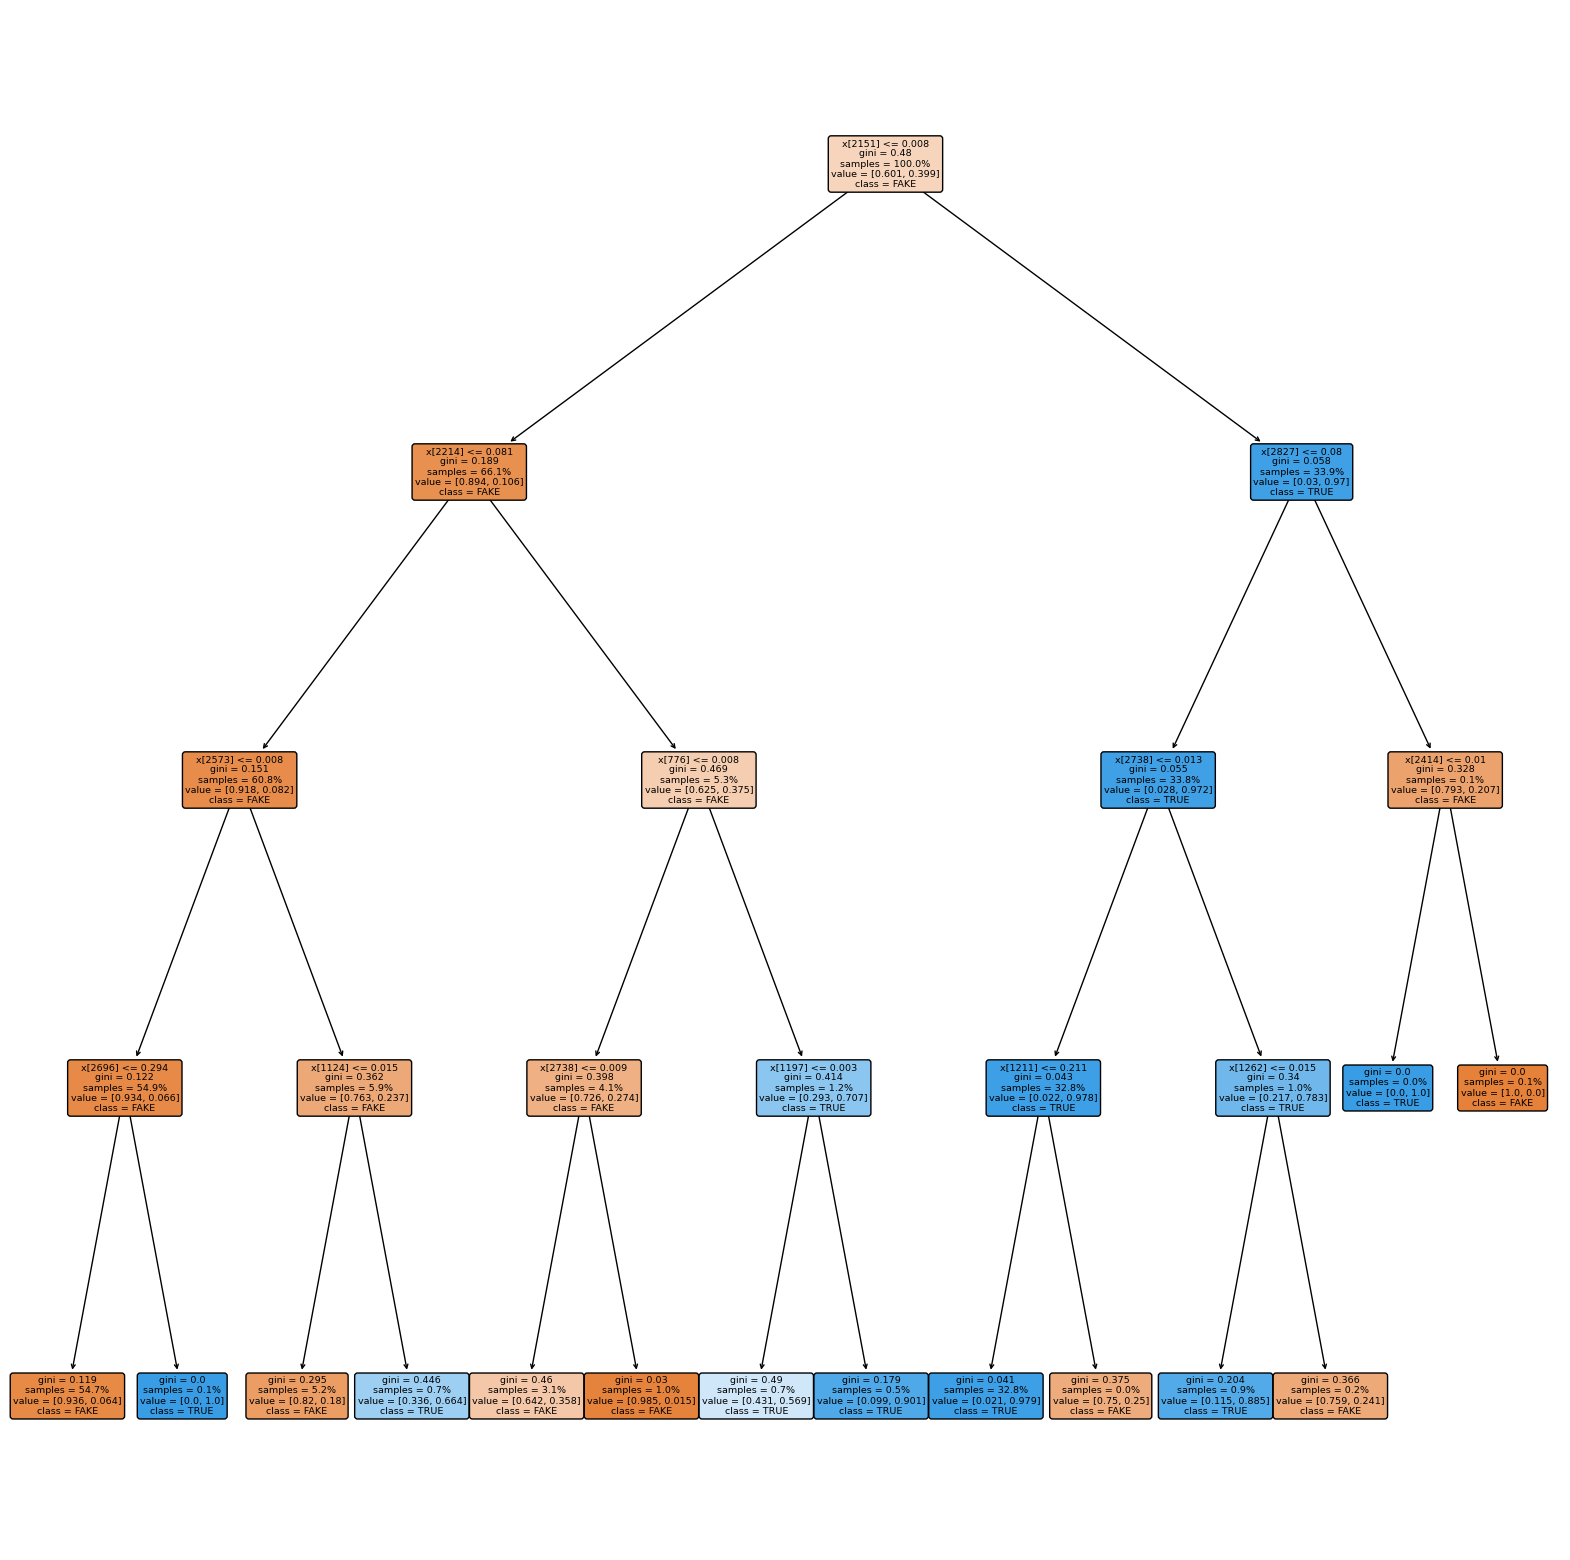

In [104]:
#what's inside the tree
plt.figure(figsize=(20,20))
plot_tree(tree_viz, filled=True, class_names=['FAKE', 'TRUE'], rounded=True, proportion=True)
plt.show()

In [12]:
#searching parameters for tree 
param_distributions = {
    'max_depth': randint(low=1, high=20),                           
    'min_samples_leaf': randint(low=1, high=10),                
    'min_samples_split': randint(low=2, high=10)
}

tree2 = DecisionTreeClassifier()
search = RandomizedSearchCV(tree2, param_distributions, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1)
search.fit(x_train, y_train)
print(search.best_params_)

{'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2}


Spróbujmy teraz użyć tych parametrów do nowego modelu.

In [8]:
#Decision Tree with parameters
tree3 = DecisionTreeClassifier(random_state=42, max_depth=12, min_samples_leaf=1, min_samples_split=2)
tree3.fit(x_train, y_train)
print('Decision Tree with parameters:')
print()
print('Train results:')
show_results2(tree3, x_train, y_train)
print()
print('Test results:')
show_results2(tree3, x_test, y_test)

Decision Tree with parameters:

Train results:
F1 score: 0.9532666274278988
Accuracy: 0.9639003394762367
Recall: 0.922813948188103
Precision: 0.9857977601038792
ROC AUC: 0.9790426964647868

Test results:
F1 score: 0.9247779590357077
Accuracy: 0.941268044155109
Recall: 0.8977652648249164
Precision: 0.9534666417492057
ROC AUC: 0.9443657733630982


Dzięki wprowadzonym zmianom udało nam się uniknąć przeuczenia modelu i doprowadziliśmy do poprawienia wyników.

## Random Forest

In [48]:
#Random Forest, no parameters
rand_forest=RandomForestClassifier(random_state=42)
rand_forest.fit(x_train,y_train.values.ravel())
print('Random Forest:')
print()
print('Train results:')
show_results2(rand_forest, x_train, y_train)
print()
print('Test results:')
show_results2(rand_forest, x_test, y_test)

Random Forest:

Train results:
F1 score: 1.0
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
ROC AUC: 1.0

Test results:
F1 score: 0.9326244385369877
Accuracy: 0.9479903764506086
Recall: 0.8951258138307232
Precision: 0.9734022196708764
ROC AUC: 0.9880587517403434


Patrząc na wyniki ponownie możemy podejrzewać, że model się przeuczył. Spróbujmy dobrać hiperparametry, aby poprawić jakość modelu. Zastosujemy do tego RandomizedSearch i crosswalidację.

In [6]:
#searching parameters for random forest
param_dist = {
    'max_depth': [10, 20, 30, 40, 50]
}
rf = RandomForestClassifier()
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)
random_search.fit(x_train, y_train.values.ravel())
print(random_search.best_params_)

C:\Users\alicj\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'max_depth': 50}


In [9]:
#Deep random forest max_depth=50
rand_forest_2 = RandomForestClassifier(random_state=42, max_depth=50)
rand_forest_2.fit(x_train, y_train.values.ravel())
print('Random Forest with parameters:')
print()
print('Train results:')
show_results2(rand_forest_2, x_train, y_train)
print()
print('Test results:')
show_results2(rand_forest_2, x_test, y_test)

Random Forest with parameters:

Train results:
F1 score: 0.9971047619047619
Accuracy: 0.9976964112512124
Recall: 0.9942262402187951
Precision: 1.0
ROC AUC: 0.9999850848127622

Test results:
F1 score: 0.9319765309864321
Accuracy: 0.947495046702519
Recall: 0.8944219602322717
Precision: 0.972822966507177
ROC AUC: 0.986741036003936


Jak widać nie zaszła większa poprawa w porównaniu do Random Forest bez hiperparametrów.

## LinearSVM

In [18]:
#Linear Support Vector Machine, no parameters
svm = LinearSVC(random_state=42)
svm.fit(x_train, y_train.values.ravel())
print('Linear SVM:')
print()
print('Train results:')
show_results(svm, x_train, y_train)
print()
print('Test results:')
show_results(svm, x_test, y_test)

Linear SVM:

Train results:
F1 score: 0.9677839494349741
Accuracy: 0.9745089718719689
Recall: 0.9596596520550027
Precision: 0.97604697882862
ROC AUC: 0.9962418555577943

Test results:
F1 score: 0.9451762192951227
Accuracy: 0.956410982168129
Recall: 0.9343656519443956
Precision: 0.9562398703403565
ROC AUC: 0.9887047492227901


 Nieźle... ale może będzie jeszcze lepiej?

In [8]:
#searching parameters for linear SVM
params = {
    'C': loguniform(1e-5, 1e5),
    'penalty': ['l2'],
    'tol': loguniform(1e-6, 1e-1),
    'dual': [True, False],
    'loss': ['squared_hinge']
}

svm2 = LinearSVC()
random_search = RandomizedSearchCV(
    svm2,
    param_distributions=params,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    random_state=42
)

random_search.fit(x_train, y_train.values.ravel())
print(random_search.best_params_)

{'C': 0.8668739724852816, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 0.0035753161317240768}


In [85]:
#with parameters
svm2 = LinearSVC(random_state=42, C=0.8668739724852816, dual=True, loss='squared_hinge', penalty='l2', tol=0.0035753161317240768)
svm2.fit(x_train, y_train.values.ravel())
print('Linear SVM:')
print()
print('Train results:')
show_results(svm2, x_train, y_train)
print()
print('Test results:')
show_results(svm2, x_test, y_test)

Linear SVM:

Train results:
F1 score: 0.9670026443873836
Accuracy: 0.9739027643064986
Recall: 0.9584441236800122
Precision: 0.9757153905645785
ROC AUC: 0.9960747732779475

Test results:
F1 score: 0.945418929748019
Accuracy: 0.9566232663458817
Recall: 0.9341896885447827
Precision: 0.9569214131218458
ROC AUC: 0.9888077364415244


Po doborze poszczególnych hiperparametrów liniowegoSVC wyniki poprawiły się o wielkości marginalne. Na tym tle bardzo dobrze wychodzi liniowySVC bez parametrów.

### Spróbujmy wykorzystać MLPClassifier (Multi-Layer Perceptor Classifier) z sklearn, zobaczymy jak poradzi sobie prosta sieć neuronowa

In [16]:
#MLP Classifier with some manually selected parameters
mlpclf = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500, alpha=0.01, solver='adam', verbose=4,  random_state=42, tol=0.000000001)
mlpclf.fit(x_train, y_train.values.ravel())
print('MLP Classifier:')
print()
print('Train results:')
show_results2(mlpclf, x_train, y_train)

Iteration 1, loss = 0.26589020
Iteration 2, loss = 0.12560633
Iteration 3, loss = 0.09594068
Iteration 4, loss = 0.07151331
Iteration 5, loss = 0.05108663
Iteration 6, loss = 0.03497524
Iteration 7, loss = 0.02671802
Iteration 8, loss = 0.02234017
Iteration 9, loss = 0.02015639
Iteration 10, loss = 0.01912260
Iteration 11, loss = 0.02209426
Iteration 12, loss = 0.02111535
Iteration 13, loss = 0.02018033
Iteration 14, loss = 0.01813541
Iteration 15, loss = 0.01637422
Iteration 16, loss = 0.01534436
Iteration 17, loss = 0.01369173
Iteration 18, loss = 0.01313374
Iteration 19, loss = 0.01181045
Iteration 20, loss = 0.01162600
Iteration 21, loss = 0.01144859
Iteration 22, loss = 0.01033214
Iteration 23, loss = 0.01061937
Iteration 24, loss = 0.00986925
Iteration 25, loss = 0.01942700
Iteration 26, loss = 0.03241513
Iteration 27, loss = 0.01870035
Iteration 28, loss = 0.01453940
Iteration 29, loss = 0.01293504
Iteration 30, loss = 0.01145085
Iteration 31, loss = 0.01094051
Iteration 32, los

In [17]:
#Perform it with test data
show_results2(mlpclf, x_test, y_test)

F1 score: 0.9504404306432958
Accuracy: 0.9605859043305972
Recall: 0.9398205173323949
Precision: 0.9613030957523399
ROC AUC: 0.9914050553541202


### Jak do tej pory najlepszy wynik ze wszystkich modeli osiągnął MLPClassifier!

### Zobaczmy jednakże czy sieć neuronowa czy voting wygra w ostatecznym rozrachunku.

# Voting

In [89]:
# voting made by soft voting, every model has the same weight (we couldn't print ROC_AUC with weight='hard' parameter)
clf = VotingClassifier(estimators=[('1', log_reg), ('2', tree3), ('3', rand_forest_2)],voting="soft")
clf.fit(x_train, y_train.values.ravel())
print('Soft voting:')
print()
print('Train results:')
show_results2(clf, x_train, y_train.values.ravel())
print()
print('Test results:')
show_results2(clf, x_test, y_test.values.ravel())

Hard voting:

Train results:
F1 score: 0.9761674842597242
Accuracy: 0.9812984966052376
Recall: 0.9599635341487502
Precision: 0.9929278642149929
ROC AUC: 0.9994357898450041

Test results:
F1 score: 0.941464742717125
Accuracy: 0.954358901783187
Recall: 0.9127221537920113
Precision: 0.9720764617691154
ROC AUC: 0.9911759218090213


Łączac powstałe modele w VotingClassifier uzyskaliśmy całkiem dobry efekt.
Zobaczymy co się stanie jeśli dodamy wagi do poszczególnych modeli.

In [61]:
#Voting with weights
clf = VotingClassifier(estimators=[('1', log_reg), ('2', rand_forest_2), ('3', tree3)], voting='soft', weights=[0.5,0.3,0.2])
clf.fit(x_train, y_train.values.ravel())



VotingClassifier(estimators=[('1',
                              LogisticRegression(C=10, random_state=42,
                                                 solver='saga')),
                             ('2', RandomForestClassifier(max_depth=50)),
                             ('3', DecisionTreeClassifier(max_depth=12))],
                 voting='soft', weights=[0.5, 0.3, 0.2])

In [62]:
#results
print('Soft voting:')
print()
print('Train results:')
show_results2(clf, x_train, y_train.values.ravel())
print()
print('Test results:')
show_results2(clf, x_test, y_test.values.ravel())

Soft voting:

Train results:
F1 score: 0.9808231812766612
Accuracy: 0.9848751212415131
Recall: 0.9694598495783636
Precision: 0.9924560584849899
ROC AUC: 0.9993800791494928

Test results:
F1 score: 0.9504132231404958
Accuracy: 0.9609397112935183
Recall: 0.9308463839521379
Precision: 0.9708203340062397
ROC AUC: 0.9919432963411713


In [ ]:
# saving model to a file
filename = "fake_news_modelv2.joblib"
joblib.dump(clf, filename)

ROC_AUC nieznacznie lepsze w Soft Votingu niż w MLPClassifier. Reszta metryk praktycznie na tym samym poziomie.
Szalę zwycięstwa przeważyła większa o 0.01 wartość Precision na korzyść Soft Votingu.

# Podsumowując
### Na przykładzie naszych danych możemy powiedzieć, że bardziej złożone modele jak np. sieć neuronowa lepiej sobie radzą w pojedynkę, chociaż liniowy SVC miał metryki zbliżone do MLPC, tak najlepsze okazało się użycie 3 prostych modeli, potencjalnie łatwo wyjaśnialnych (drzewa decyzyjnego, lasu losowego i regresji logistycznej)w formie soft votingu.

### Ostatecznie to przeprowadzony przez nas na koniec soft voting wybieramy jako wdrożeniowy do klasyfikacji fake newsów.

# Spójrzmy jeszcze tylko na predykcyjność zmiennych w uzyskanym modelu.

### Najpierw predykcyjność zmiennych w regresji logistycznej.

In [11]:
#Let's see the coefficients of logistic regression
df_log = pd.DataFrame(log_reg.coef_.transpose(), 
             x_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
print(df_log)

              coef
reuter   61.628527
said     15.657647
monday    8.648112
that      8.085953
there     7.995052
...            ...
hillari  -9.131831
wire     -9.908340
video   -10.350829
novemb  -12.062499
via     -30.244109

[2877 rows x 1 columns]


### Zobaczmy 30 zmiennych najbardziej wpływających na wynik, że news jest prawdziwy.

In [12]:
#Words with the highest impact on the result with True label
print(df_log.head(30))

                 coef
reuter      61.628527
said        15.657647
monday       8.648112
that         8.085953
there        7.995052
say          7.766980
friday       7.371080
tuesday      7.197679
sept         7.141115
didnt        6.663471
hasnt        6.636641
what         6.579690
thursday     6.564360
editori      6.396506
weve         6.338837
unfold       6.230455
he           5.931960
ive          5.928703
isnt         5.903587
strategi     5.872880
sunday       5.740894
wednesday    5.576837
bbc          5.572485
dont         5.522122
wasnt        5.396078
washington   5.335207
vast         5.314413
impact       5.275613
conserv      5.261386
impos        5.156050


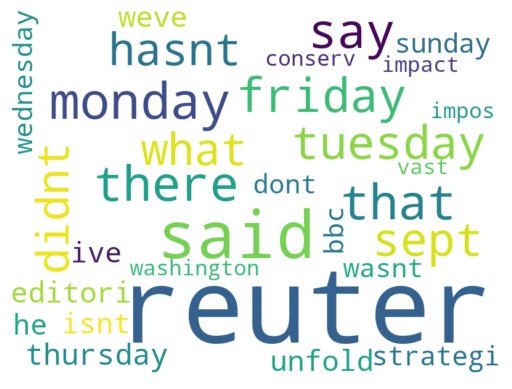

In [15]:
#Words to be visualized
word_dict = df_log.head(30).to_dict()
wc = wordcloud.WordCloud(width=800, height=600, background_color='white', relative_scaling=0.5).generate_from_frequencies(word_dict['coef'])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Czy reuters jest wyznacznikiem prawdziwych informacji hmmmmm?

### A teraz 30 zmiennych najbardziej wpływających na wynik, że news jest fałszywy.

In [72]:
#Words with the highest impact on the result with False label
print(df_log.tail(30))

                 coef
permiss     -5.356644
ignor       -5.359353
alien       -5.363327
cancel      -5.387437
went        -5.400342
reportedli  -5.591618
hate        -5.648543
know        -5.677202
caller      -5.705149
breitbart   -5.813387
expos       -6.002418
load        -6.139069
centuri     -6.217469
massiv      -6.355350
share       -6.405433
howev       -6.638268
taxpay      -6.676599
mail        -6.821721
articl      -6.915020
entir       -7.048481
go          -7.254857
daili       -7.282400
break       -8.400983
cent        -8.654428
octob       -8.864583
hillari     -9.131831
wire        -9.908340
video      -10.350829
novemb     -12.062499
via        -30.244109


C:\Users\bfgam\AppData\Local\Temp\ipykernel_11780\2510404944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail['coef'] = tail['coef'].map(lambda x: abs(x))


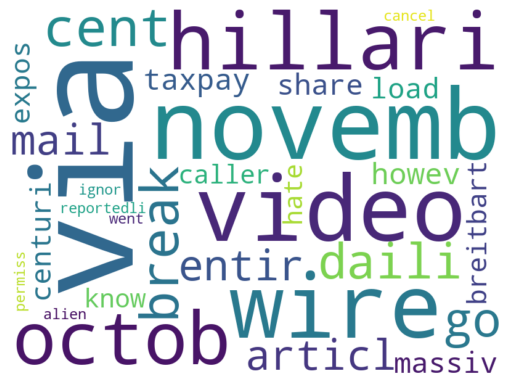

In [73]:
#Words to be visualized again
tail = df_log.tail(30)
tail['coef'] = tail['coef'].map(lambda x: abs(x))
word_dict = tail.to_dict()
wc = wordcloud.WordCloud(width=800, height=600, background_color='white', relative_scaling=0.5).generate_from_frequencies(word_dict['coef'])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Spójrzmy teraz, które zmienne najbardziej wpływają na wynik w Decision Tree. Przejrzyjmy znowu 30 najbardziej wpływających.

In [74]:
#The most important features for Random Forest
df_tree = pd.DataFrame(tree3.feature_importances_.transpose(), 
             x_train.columns, 
             columns=['importance'])\
            .sort_values(by='importance', ascending=False)
print(df_tree.head(30))

           importance
reuter       0.806460
said         0.023368
via          0.011345
dont         0.008622
that         0.008392
gop          0.006997
hillari      0.006224
cnn          0.004822
unfold       0.004600
kill         0.004004
sen          0.003585
he           0.003124
contribut    0.002932
error        0.002850
imag         0.002755
nomin        0.002564
wire         0.002472
syrian       0.002440
your         0.002351
occasion     0.002268
primari      0.002161
percent      0.001925
tax          0.001907
gov          0.001762
help         0.001600
sweep        0.001548
bbc          0.001542
video        0.001433
aleppo       0.001432
report       0.001318


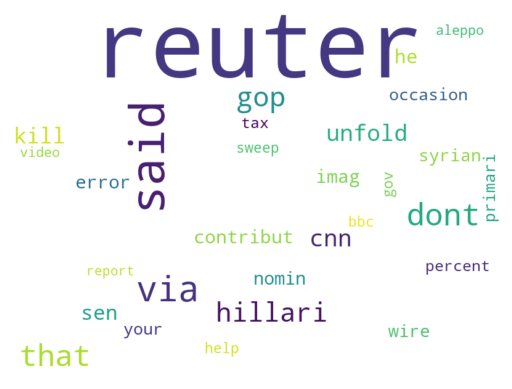

In [75]:
#Words with the highest impact on the result with decision tree
word_dict = df_tree.head(30).to_dict()
wc = wordcloud.WordCloud(width=800, height=600, background_color='white', relative_scaling=0.5).generate_from_frequencies(word_dict['importance'])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Teraz zróbmy to samo dla Random Forest.

In [76]:
#The most important features for Random Forest
df_forest = pd.DataFrame(rand_forest_2.feature_importances_.transpose(), 
             x_train.columns, 
             columns=['importance'])\
            .sort_values(by='importance', ascending=False)
print(df_forest.head(30))

            importance
reuter        0.157052
said          0.066383
video         0.022038
via           0.016462
washington    0.014104
minist        0.012243
imag          0.011819
thursday      0.009176
hillari       0.007450
monday        0.007219
even          0.006781
friday        0.006256
wednesday     0.006215
tuesday       0.006151
spokesman     0.005950
senat         0.005856
us            0.005295
fact          0.005165
actual        0.004950
told          0.004940
know          0.004514
watch         0.004475
lawmak        0.004409
leader        0.004332
get           0.004080
america       0.004021
statement     0.004020
presid        0.003844
like          0.003831
prime         0.003664


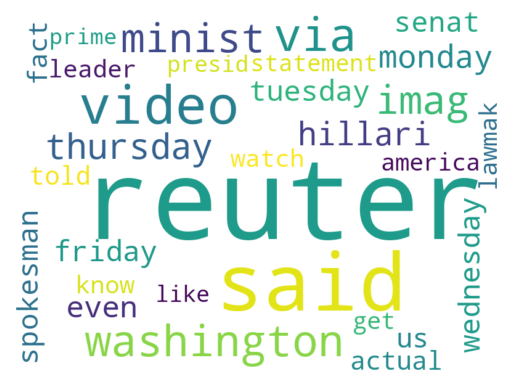

In [77]:
#Words with the highest impact on the result with random forest
word_dict = df_forest.head(30).to_dict()
wc = wordcloud.WordCloud(width=800, height=600, background_color='white', relative_scaling=0.5).generate_from_frequencies(word_dict['importance'])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Poprawki po prezentacji

Już przed prezentacją patrzyliśmy podejrzliwie na ogromny wpływ słowa reuter na nasze modele. Zwrócono nam również uwagę na obecność innych nazw popularnych mediów, nazw dni tygodnia i miesiąców wśród słów najbardziej wpływających na nasze modele. Mogłoby to stanowić problem w warunkach wdrożeniowych. Spróbujemy usunąć te kolumny i zobaczyć, jak to wpłynie na nasze modele. Porównamy wyniki jedynie dla naszego ostatecznego modelu.

In [7]:
x_train.columns

Index(['abandon', 'abc', 'abedin', 'abil', 'abl', 'abort', 'abroad', 'absolut',
       'absurd', 'abus',
       ...
       'youll', 'young', 'younger', 'your', 'youth', 'youtub', 'youv', 'zero',
       'zone', 'upper_ratio'],
      dtype='object', length=2885)

In [26]:
x_train1 = x_train.drop(['reuter', 'cnn', 'bbc', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'novemb', 'octob', 'august', 'januari', 'februari',
                        'march', 'april', 'june', 'juli', 'septemb', 'decemb'], axis=1)
x_test1 = x_test.drop(['reuter', 'cnn', 'bbc', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'novemb', 'octob', 'august', 'januari', 'februari',
                        'march', 'april', 'june', 'juli', 'septemb', 'decemb'], axis=1)

## Poprawiona regresja logistyczna

In [27]:
#Logistic Regression with parameters
log_reg=LogisticRegression(C=10, random_state=42, solver='saga', max_iter=100)
log_reg.fit(x_train1, y_train.values.ravel())
print('Logistic Regression:')
print()
print('Train results:')
show_results(log_reg, x_train1, y_train)
print()
print('Test results:')
show_results(log_reg, x_test1, y_test)

Logistic Regression:

Train results:
F1 score: 0.9500113955785155
Accuracy: 0.9601067054686553
Recall: 0.9454861636171178
Precision: 0.9545801526717558
ROC AUC: 0.9924548195658993

Test results:
F1 score: 0.9214292142921428
Accuracy: 0.938247152861286
Recall: 0.9126403993581743
Precision: 0.930388949472919
ROC AUC: 0.982201656276749


Wyniki są trochę gorsze, ale nadal bardzo dobre. Spójrzmy, które zmienne teraz najbardziej wpływają na regresję logistyczną.

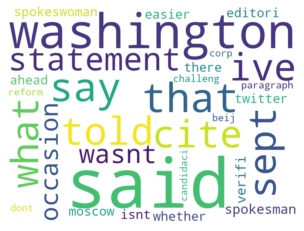

In [28]:
#Let's see the coefficients of logistic regression
df_log = pd.DataFrame(log_reg.coef_.transpose(), 
             x_train1.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

#Words to be visualized
word_dict = df_log.head(30).to_dict()
wc = wordcloud.WordCloud(width=800, height=600, background_color='white', relative_scaling=0.5).generate_from_frequencies(word_dict['coef'])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<ipython-input-36-9d85266a92fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail['coef'] = tail['coef'].map(lambda x: abs(x))


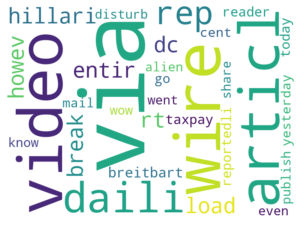

In [36]:
#Words to be visualized again
tail = df_log.tail(30)
tail['coef'] = tail['coef'].map(lambda x: abs(x))
word_dict = tail.to_dict()
wc = wordcloud.WordCloud(width=800, height=600, background_color='white', relative_scaling=0.5).generate_from_frequencies(word_dict['coef'])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Poprawione drzewo decyzyjne

In [29]:
#Decision Tree with parameters
tree3 = DecisionTreeClassifier(random_state=42, max_depth=12, min_samples_leaf=1, min_samples_split=2)
tree3.fit(x_train1, y_train)
print('Decision Tree with parameters:')
print()
print('Train results:')
show_results2(tree3, x_train1, y_train)
print()
print('Test results:')
show_results2(tree3, x_test1, y_test)

Decision Tree with parameters:

Train results:
F1 score: 0.8962441855995079
Accuracy: 0.918182369346429
Recall: 0.8813700287312869
Precision: 0.9116289982012982
ROC AUC: 0.9559824553958323

Test results:
F1 score: 0.8353208921256258
Accuracy: 0.8720379146919431
Recall: 0.8179711178463184
Precision: 0.8534226190476191
ROC AUC: 0.8942430827633289


Wyniki w drzewie decyzyjnym są o wiele gorsze. Przypomnijmy, że na początku polegało ono bardzo na słowie 'reuter', które usunęliśmy. Zobaczmy, które słowa teraz są ważne w modelu.

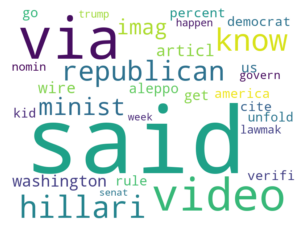

In [30]:
#The most important features for Random Forest
df_tree = pd.DataFrame(tree3.feature_importances_.transpose(), 
             x_train1.columns, 
             columns=['importance'])\
            .sort_values(by='importance', ascending=False)
#Words with the highest impact on the result with decision tree
word_dict = df_tree.head(30).to_dict()
wc = wordcloud.WordCloud(width=800, height=600, background_color='white', relative_scaling=0.5).generate_from_frequencies(word_dict['importance'])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Widzimy, że drzewo tym razem nie polega głównie tylko na jednym słowie, tylko trochę ważność poszczególnych kolumn się rozłożyła. Mimo gorszych wyników, uznajemy to za lepsze, gdyż model dzięki temu będzie bardziej stabilny.

## Poprawiony las losowy

In [32]:
#Deep random forest max_depth=50
rand_forest_2 = RandomForestClassifier(random_state=42, max_depth=50)
rand_forest_2.fit(x_train1, y_train.values.ravel())
print('Random Forest with parameters:')
print()
print('Train results:')
show_results2(rand_forest_2, x_train1, y_train)
print()
print('Test results:')
show_results2(rand_forest_2, x_test1, y_test)

Random Forest with parameters:

Train results:
F1 score: 0.9975746551462786
Accuracy: 0.9980599005699042
Recall: 0.9951610464237108
Precision: 1.0
ROC AUC: 0.9999791963347656

Test results:
F1 score: 0.9128469980632666
Accuracy: 0.9331541345405673
Recall: 0.882331966482439
Precision: 0.9455483377913642
ROC AUC: 0.9810902293018089


O dziwo las losowy bardzo się nie pogorszył. Jedynie odrobinę się przeuczył. Zobaczmy co jest w środku tym razem.

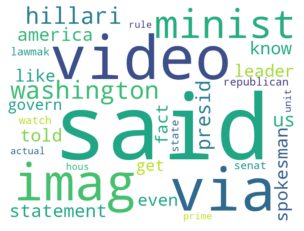

In [33]:
#The most important features for Random Forest
df_forest = pd.DataFrame(rand_forest_2.feature_importances_.transpose(), 
             x_train1.columns, 
             columns=['importance'])\
            .sort_values(by='importance', ascending=False)

#Words with the highest impact on the result with random forest
word_dict = df_forest.head(30).to_dict()
wc = wordcloud.WordCloud(width=800, height=600, background_color='white', relative_scaling=0.5).generate_from_frequencies(word_dict['importance'])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Porównajmy teraz wyniki poprzedniego soft votingu, z soft votingiem z poprawkami. Przypomnijmy, jak wyglądały wyniki poprzednio:

Train results:
F1 score: 0.9761674842597242 <br/>
Accuracy: 0.9812984966052376 <br/>
Recall: 0.9599635341487502 <br/>
Precision: 0.9929278642149929 <br/>
ROC AUC: 0.9994357898450041<br/>
<br/>
Test results:<br/>
F1 score: 0.941464742717125<br/>
Accuracy: 0.954358901783187<br/>
Recall: 0.9127221537920113<br/>
Precision: 0.9720764617691154<br/>
ROC AUC: 0.9911759218090213

In [35]:
#Voting with weights
clf = VotingClassifier(estimators=[('1', log_reg), ('2', rand_forest_2), ('3', tree3)], voting='soft', weights=[0.5,0.3,0.2])
clf.fit(x_train, y_train.values.ravel())
#results
print('Soft voting:')
print()
print('Train results:')
show_results2(clf, x_train, y_train.values.ravel())
print()
print('Test results:')
show_results2(clf, x_test, y_test.values.ravel())

Soft voting:

Train results:
F1 score: 0.9808434978778725
Accuracy: 0.9848126591487814
Recall: 0.9697565401481929
Precision: 0.9921868956447745
ROC AUC: 0.9993500973240415

Test results:
F1 score: 0.9504207830223198
Accuracy: 0.9616608898634789
Recall: 0.9261900517026208
Precision: 0.9759534097313545
ROC AUC: 0.9922461121013969


Ku naszemu zaskoczeniu, wyniki votingu wyszły lepiej niż poprzednio. Najwyraźniej modele, mimo słabszych osiągów tym razem, skupiły się na innych kolumnach, gdy kolumny takie, jak 'reuter' już nie przeważały. Dzięki temu uzyskały lepszy wynik współpracując w soft votingu.